In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_auc_score,
    log_loss,
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

np.random.seed(42)

DATA_DIR = Path("data") / "processed"
events_path = DATA_DIR / "ad_events_processed.csv"

events_df = pd.read_csv(events_path)
events_df.head()

,user_id,ad_id,user_age_bucket,user_location,user_device,user_base_ctr,ad_category,ad_quality_score,ad_base_ctr,bid,time_of_day,interest_match,true_ctr,clicked
0,46993,646,35-44,Tier-3,android,0.031010,fashion,0.852224,0.037387,1.79,morning,0,0.600000,1
1,15268,707,25-34,Tier-2,android,0.039462,electronics,0.588347,0.025422,4.95,evening,0,0.575525,1
2,65066,552,35-44,Tier-2,android,0.023422,fashion,0.818090,0.052376,3.24,morning,0,0.600000,0
3,26740,640,25-34,Tier-2,ios,0.047996,electronics,0.838686,0.040108,2.28,evening,0,0.600000,1
4,69272,643,25-34,Tier-2,ios,0.054098,electronics,0.711505,0.041477,4.70,evening,0,0.600000,1


In [2]:
categorical_features = [
    "user_age_bucket",
    "user_location",
    "user_device",
    "ad_category",
    "time_of_day",
]

numeric_features = [
    "bid",
    "ad_quality_score",
    "user_base_ctr",
    "ad_base_ctr",
    "interest_match",
]

feature_cols = categorical_features + numeric_features
target_col = "clicked"

X = events_df[feature_cols]
y = events_df[target_col].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, categorical_features),
        ("num", num_transformer, numeric_features),
    ]
)

In [3]:
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    n_jobs=-1,
    random_state=42,
)

lgbm_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", lgbm),
    ]
)

lgbm_pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 918014, number of negative: 681986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 1600000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573759 -> initscore=0.297204
[LightGBM] [Info] Start training from score 0.297204


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [5]:
y_train_proba = lgbm_pipe.predict_proba(X_train)[:, 1]
y_val_proba = lgbm_pipe.predict_proba(X_val)[:, 1]

print("Train AUC:", roc_auc_score(y_train, y_train_proba))
print("Val   AUC:", roc_auc_score(y_val, y_val_proba))
print("Val logloss:", log_loss(y_val, y_val_proba))

/Users/utkarshsingh/ClickRank/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/utkarshsingh/ClickRank/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.5846649041449243
Val   AUC: 0.5470382823861468
Val logloss: 0.6721092267548199


In [6]:
events_df["pctr_lgbm"] = lgbm_pipe.predict_proba(X)[:, 1]
events_df[["true_ctr", "pctr_lgbm", "clicked"]].head()

/Users/utkarshsingh/ClickRank/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,true_ctr,pctr_lgbm,clicked
0,0.600000,0.598403,1
1,0.575525,0.582676,1
2,0.600000,0.593466,0
3,0.600000,0.597534,1
4,0.600000,0.600266,1


### Building Auction

In [7]:
K = 5

events_shuffled = events_df.sample(frac=1.0, random_state=42).reset_index(drop = True)
n_full = (len(events_shuffled)//K) * K
events_shuffled = events_shuffled.iloc[:n_full].copy()

events_shuffled["auction_id"] =np.repeat( np.arange(n_full//K),K)

events_shuffled.head(10)
events_shuffled["auction_id"].nunique() , events_shuffled.groupby("auction_id")

(400000, <pandas.core.groupby.generic.DataFrameGroupBy object at 0x12ab48d70>)

In [8]:
def simulate_strategy(df: pd.DataFrame, score_column: str, top_k: int = 1):
    df = df.copy()
    df["score"] = df[score_column]

    df_sorted = df.sort_values(["auction_id", "score"], ascending=[True, False])

    winners = df_sorted.groupby("auction_id").head(top_k)  #This makes sure to select exactly 1 top advertisement 

    total_auctions = winners["auction_id"].nunique()
    total_impressions = len(winners)
    total_clicks = winners["clicked"].sum()

    revenue_per_click = winners["bid"]
    total_revenue = (revenue_per_click * winners["clicked"]).sum()

    ctr = total_clicks / total_impressions
    rev_per_impr = total_revenue / total_impressions

    return {
        "strategy": score_column,
        "auctions": total_auctions,
        "impressions": total_impressions,
        "clicks": int(total_clicks),
        "CTR": ctr,
        "revenue": total_revenue,
        "revenue_per_impression": rev_per_impr,
    }


events_shuffled["score_bid"] = events_shuffled["bid"]                                  # Ranking ADs by highest BID only making sure revenue is maximised
events_shuffled["score_pctr"] = events_shuffled["pctr_lgbm"]                           # Ranking ADs by user engagement or predicted CTR
events_shuffled["score_ecpm"] = events_shuffled["bid"] * events_shuffled["pctr_lgbm"]  # Ranking ADs by expected revenue = (bid * pCTR)

results = []
results.append(simulate_strategy(events_shuffled, "score_bid"))
results.append(simulate_strategy(events_shuffled, "score_pctr"))
results.append(simulate_strategy(events_shuffled, "score_ecpm"))

results_df = pd.DataFrame(results)
results_df

,strategy,auctions,impressions,clicks,CTR,revenue,revenue_per_impression
0,score_bid,400000,400000,234390,0.585975,1249986.21,3.124966
1,score_pctr,400000,400000,255968,0.639920,979195.34,2.447988
2,score_ecpm,400000,400000,239028,0.597570,1265390.03,3.163475


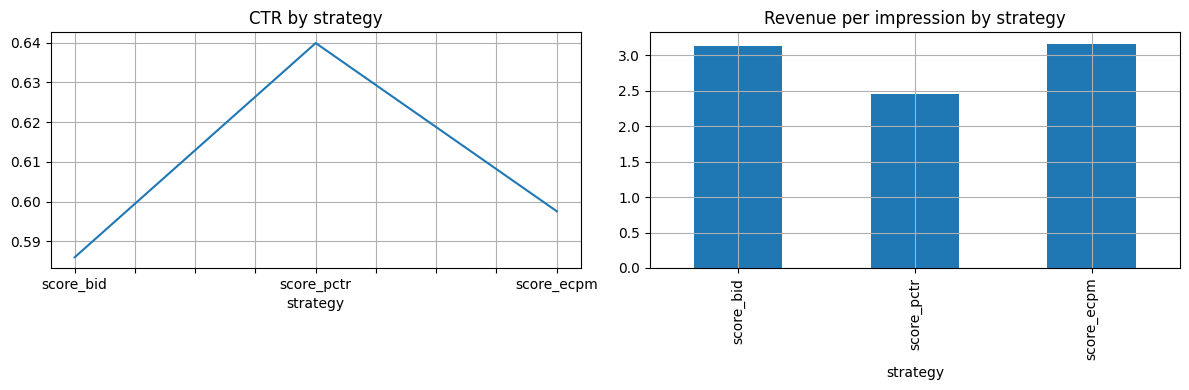

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

results_df.plot(x="strategy", y="CTR", kind="line", ax=axes[0], legend=False)
axes[0].set_title("CTR by strategy")

results_df.plot(x="strategy", y="revenue_per_impression", kind="bar", ax=axes[1], legend=False)
axes[1].set_title("Revenue per impression by strategy")

plt.tight_layout()
plt.show()